In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import scipy.sparse as sp
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
import matplotlib.pyplot as plt


In [2]:
# import df.csv

df = pd.read_csv('df.csv')

/tmp/ipykernel_195590/3391109823.py:3: DtypeWarning: Columns (27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df.csv')


In [3]:
# Assume your dataframe is df and your date column is 'date'

# Convert date to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df.sort_values('Date', inplace=True)

# Remove rows where the 'Injury' column has NA values
df = df.dropna(subset=['Injury'])

# Get unique dates
unique_dates = df['Date'].unique()

# Decide how many dates to include in each set
train_dates = int(len(unique_dates) * 0.8)

# Find the index of the last training date
last_train_idx = df[df['Date'] == unique_dates[train_dates]].index[-1]

# Now you can create your train and test sets
train = df.iloc[:last_train_idx + 1]
test = df.iloc[last_train_idx + 1:]



In [4]:
# Identify categorical columns excluding the date column
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')

# Fit the OneHotEncoder on the training data and transform both train and test data
ohe.fit(train[cat_cols])
one_hot_encoded_train = ohe.transform(train[cat_cols])
one_hot_encoded_test = ohe.transform(test[cat_cols])

# Extract numeric data
numeric_data_train = train.drop(cat_cols + ['Date', 'Injury'], axis=1).values
numeric_data_test = test.drop(cat_cols + ['Date', 'Injury'], axis=1).values


# Combine sparse and dense data
final_data_train = sp.hstack((one_hot_encoded_train, numeric_data_train)).tocsr()
final_data_test = sp.hstack((one_hot_encoded_test, numeric_data_test)).tocsr()



# Set up for cross-validation
X = final_data_train
y = train["Injury"].values  # replace "Injury" with your target column name

# Initialize a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)



/home/n0rdp0l/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
rows, cols = X.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {cols}")


Number of rows: 223854
Number of columns: 284


In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 1.0),
        'objective': 'reg:squarederror'
    }

    mse_scores = []

    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train_cv, y_train_cv)

        y_pred = model.predict(X_val_cv)
        mse = mean_squared_error(y_val_cv, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params_

final_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
final_model.fit(X, y)

predictions = final_model.predict(final_data_test)

In [11]:
# Extract hyperparameters from trial 4
best_params = {'learning_rate': 0.4033386560764858, 
               'max_depth': 6, 
               'n_estimators': 453, 
               'subsample': 0.8280774098649553, 
               'colsample_bytree': 0.9340110099277303, 
               'gamma': 0.8680536696218003,
               'objective': 'reg:squarederror'}

# Train the model with the best parameters on the entire training data
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X, y)

# Prepare the test data
X_test = final_data_test
y_test = test["Injury"].values  # replace "Injury" with your target column name

# Make predictions on the test data
predictions_test = final_model.predict(X_test)

# Calculate mean squared error on the test data
mse_test = mean_squared_error(y_test, predictions_test)

print("Mean squared error on the test data: ", mse_test)


Mean squared error on the test data:  0.00028657659154883273


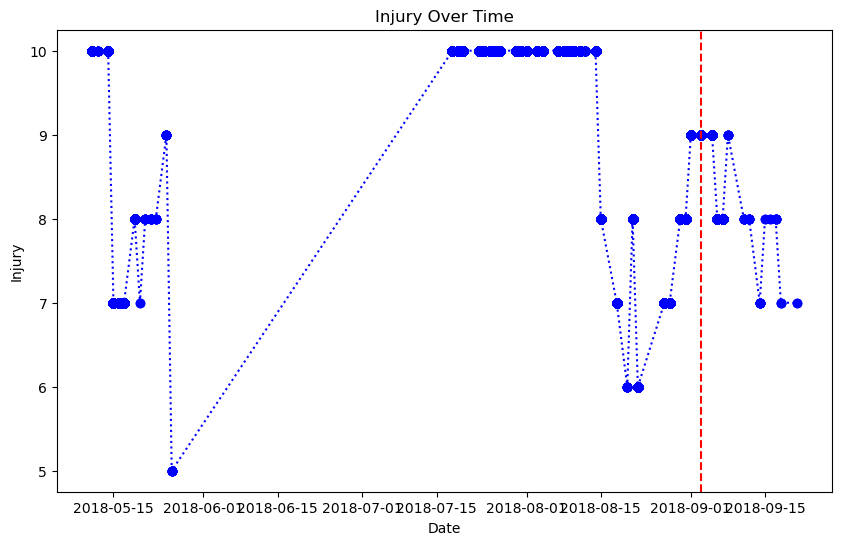

In [22]:
# Assuming 'df' is your DataFrame containing the 'Date' and 'Injury' columns
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Injury'], marker='o', linestyle=':', color='blue')

# Calculating the cutoff date at 80% of the data
cutoff_percentage = 0.8
cutoff_index = int(len(df) * cutoff_percentage)
cutoff_date = df['Date'].iloc[cutoff_index]

# Adding the vertical red dotted line at the cutoff date
plt.axvline(x=cutoff_date, color='red', linestyle='--')

plt.title('Injury Over Time')
plt.xlabel('Date')
plt.ylabel('Injury')
plt.show()

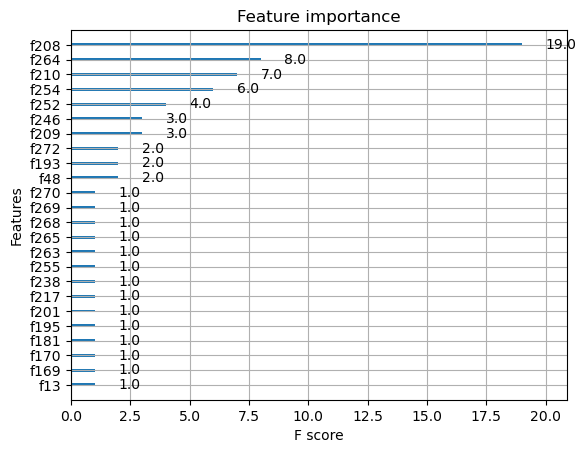

In [12]:


# Let's plot the feature importance
xgb.plot_importance(final_model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()


In [20]:
# Get one-hot encoded feature names
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# Get numeric feature names
numeric_feature_names = train.drop(cat_cols + ['Date'], axis=1).columns

# Combine both lists
all_feature_names = np.concatenate([ohe_feature_names, numeric_feature_names])

# Now you can find the original feature name for a given index
print(all_feature_names[211])


Injury_lag_3
